In [59]:
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline

df_necessities, df_customer, df_market_add

### 생필품 가격 - 유동인구수 상관분석을 위한 dataframe

In [53]:
df1 = pd.merge(df_necessities, df_customer, on=['년도','분기','시장이름'], how='left')
df1

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1621162,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
1,1628949,남부종합시장,호박,1개268g,1500,2020-12,서초구,2020,4,76782.0,...,174.0,176.0,240.0,182.0,358.0,303.0,180.0,175.0,247.0,188.0
2,1622882,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
3,1622883,통인시장,상추(100g),400g,3000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
4,1622885,통인시장,호박(인큐베이터),1개,1000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167863,449830,구로시장,달걀,10개,1500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167864,449831,구로시장,"조기(냉동,수입산)",1마리(20cm),1500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167865,449832,구로시장,"명태(러시아,냉동)",1마리(42cm),1700,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167866,449833,구로시장,"오징어(생물,국산)",1마리,2500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167868 entries, 0 to 167867
Columns: 535 entries, 일련번호 to 여성연령대_60_이상_일요일시간대_6_생활인구_수
dtypes: float64(526), int64(4), object(5)
memory usage: 686.5+ MB


In [55]:
# null 확인
# merge를 잘못한게 아니라 특정 년도(2013년), 분기에 유동인구 데이터가 없는 행들임
df1[df1['총_생활인구_수'].isnull()]

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
332,1629319,신창시장,양파,1망(800g),1500,2020-12,도봉구,2020,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,1629318,신창시장,무,1개(1.5kg),2000,2020-12,도봉구,2020,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,1629317,신창시장,배추,1포기(2.4kg),3000,2020-12,도봉구,2020,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,1629316,신창시장,배,1개(754g),3000,2020-12,도봉구,2020,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
336,1626728,신창시장,호박,1개(340g),1300,2020-12,도봉구,2020,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167863,449830,구로시장,달걀,10개,1500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167864,449831,구로시장,"조기(냉동,수입산)",1마리(20cm),1500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167865,449832,구로시장,"명태(러시아,냉동)",1마리(42cm),1700,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167866,449833,구로시장,"오징어(생물,국산)",1마리,2500,2013-05,구로구,2013,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# 결측값이 있는 행 전체 제거
df1 = df1[df1['총_생활인구_수'].notna()]

In [57]:
df1[df1['총_생활인구_수'].isnull()]

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수


In [ ]:
# 생필품가격 - 유동인구수 상관관계 분석 및 시각화를 위해 외부저장
df1.to_csv('../datas/huge/df_necessity_market_customer.csv', encoding='cp949')

In [2]:
df = pd.read_csv('../datas/huge/df_necessity_market_customer.csv', encoding='cp949')

In [3]:
df = df.drop(['Unnamed: 0'], axis=1)

In [92]:
df

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1621162,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
1,1628949,남부종합시장,호박,1개268g,1500,2020-12,서초구,2020,4,76782.0,...,174.0,176.0,240.0,182.0,358.0,303.0,180.0,175.0,247.0,188.0
2,1622882,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
3,1622883,통인시장,상추(100g),400g,3000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
4,1622885,통인시장,호박(인큐베이터),1개,1000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147356,557873,방이시장,달걀(특란),10개,2900,2014-01,송파구,2014,1,283082.0,...,365.0,317.0,322.0,47.0,0.0,92.0,190.0,189.0,204.0,34.0
147357,557874,방이시장,"조기(냉동,국산)",1마리(20cm),2000,2014-01,송파구,2014,1,283082.0,...,365.0,317.0,322.0,47.0,0.0,92.0,190.0,189.0,204.0,34.0
147358,557875,방이시장,"명태(러시아,냉동)",1마리(35cm),2400,2014-01,송파구,2014,1,283082.0,...,365.0,317.0,322.0,47.0,0.0,92.0,190.0,189.0,204.0,34.0
147359,557876,방이시장,"오징어(냉동,국산)",1마리(25cm),1980,2014-01,송파구,2014,1,283082.0,...,365.0,317.0,322.0,47.0,0.0,92.0,190.0,189.0,204.0,34.0


In [95]:
# 중복행 제거 147361 rows -> 22039 rows
df = df.drop_duplicates(['시장이름','품목이름', '년도', '분기', '총_생활인구_수'])
df

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,1621162,통인시장,양파(1.5kg망),1kg,2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
1,1628949,남부종합시장,호박,1개268g,1500,2020-12,서초구,2020,4,76782.0,...,174.0,176.0,240.0,182.0,358.0,303.0,180.0,175.0,247.0,188.0
3,1622883,통인시장,상추(100g),400g,3000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
4,1622885,통인시장,호박(인큐베이터),1개,1000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
5,1622886,통인시장,"쇠고기(한우,불고기)",600g2등급,23000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147199,557492,뚝도시장,"오징어(생물,국산)",1마리,2500,2014-01,성동구,2014,1,62811.0,...,71.0,74.0,74.0,11.0,0.0,10.0,28.0,29.0,30.0,1.0
147248,557669,암사종합시장,"고등어(생물,국산)",1마리(30cm),4000,2014-01,강동구,2014,1,182549.0,...,289.0,245.0,287.0,67.0,0.0,94.0,159.0,171.0,223.0,48.0
147263,557684,둔촌역전통시장,"오징어(생물,국산)",1마리,2500,2014-01,강동구,2014,1,342016.0,...,555.0,487.0,543.0,140.0,1.0,200.0,327.0,342.0,364.0,78.0
147264,557685,둔촌역전통시장,"고등어(생물,국산)",1마리(30cm),4000,2014-01,강동구,2014,1,342016.0,...,555.0,487.0,543.0,140.0,1.0,200.0,327.0,342.0,364.0,78.0


In [97]:
#pd.set_option('display.max_rows', None)

In [98]:
#품목의 빈도수 계산
freq = df[['시장이름','품목이름']].groupby(['품목이름']).count()
freq_s = freq.sort_values(by = ['시장이름'], ascending = False)
freq_s

## wtf.. 진즉 중복처리하고 빈도수 계산할걸 그랬네요 달걀(10개) 삽질 무엇;;;;;;ㅇ;ㄻㄴㄹ넝류ㅏㅣㅓ무너ㅏㅣ루

,시장이름
품목이름,
오이(다다기),1090
"쇠고기(한우,불고기)",996
배추(2.5~3kg),961
닭고기(육계),928
"사과(부사, 300g)",922
"고등어(생물,국산)",910
돼지고기(생삼겹살),863
"배(신고, 600g)",854
상추(100g),835


In [101]:
df[['시장이름','총_생활인구_수']].drop_duplicates(['시장이름']).sort_values(by = ['총_생활인구_수'], ascending = False)

,시장이름,총_생활인구_수
468,영등포전통시장,1064795.0
687,신원시장,1035813.0
3972,상계중앙시장,999759.0
2691,방이시장,994076.0
716,우림골목시장,925157.0
357,동원시장,895308.0
1439,남대문시장,871867.0
691,자양골목시장,801937.0
2477,서울중앙시장,731202.0
1712,현대시장,618654.0


시장별로 유동인구수 차이가 크다해도 가격이 변함에 따라 유동인구수도 변한다면 상관계수값에는 영향이 없을지도?

특정시장 분기별(7 * 4 = 28row) 특정품목 가격 - 유동인구

함수로 자동화 - 
품목이름만 넣으면 알아서 outlier 제거하고 시장별로 상관계수값뽑고 산점도, 지도시각화 -> 가격정책이 유의미한 시장 찾음 




### 달걀(10개) 가격 - 유동인구수 상관분석 및 시각화 

필터링 순서
1. 품목이름이 '달걀' 포함
2. 실판매규격이 '10개' 포함

In [9]:
df_none= pd.DataFrame(columns = df.columns)
df_none

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수


In [10]:
# 1번 필터링
df_egg = pd.concat([df_none,df[df['품목이름'].str.contains('달걀')]])

In [11]:
df_egg

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
8,1622889,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
9,1622890,통인시장,달걀(30개),30개(1800g),5000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
14,1626243,통인시장,달걀(30개),30개(1800g),5000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
21,1629972,통인시장,달걀(30개),30개(1800g),5000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
22,1629971,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147296,557749,수유전통시장,달걀,10알,1666,2014-01,강북구,2014,1,214611.0,...,491.0,445.0,466.0,84.0,0.0,112.0,287.0,317.0,340.0,37.0
147308,557825,노룬산골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,17006.0,...,15.0,12.0,14.0,2.0,0.0,1.0,2.0,1.0,6.0,0.0
147324,557841,자양골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,145674.0,...,232.0,188.0,214.0,42.0,0.0,59.0,119.0,124.0,157.0,26.0
147340,557857,마천시장,달걀(특란),10개,2900,2014-01,송파구,2014,1,109409.0,...,249.0,231.0,250.0,25.0,0.0,42.0,128.0,155.0,165.0,10.0


In [12]:
# 2번 필터링
df_egg_10 = pd.concat([df_none, df_egg[df_egg['실판매규격'].str.contains('10개')]])

In [13]:
df_egg_10

,일련번호,시장이름,품목이름,실판매규격,가격(원),년도-월,자치구이름,년도,분기,총_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
8,1622889,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
22,1629971,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
52,1626783,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
75,1629377,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
81,1625200,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147280,557733,숭인시장,달걀,10개,1666,2014-01,강북구,2014,1,122068.0,...,273.0,243.0,268.0,77.0,2.0,97.0,162.0,173.0,192.0,46.0
147308,557825,노룬산골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,17006.0,...,15.0,12.0,14.0,2.0,0.0,1.0,2.0,1.0,6.0,0.0
147324,557841,자양골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,145674.0,...,232.0,188.0,214.0,42.0,0.0,59.0,119.0,124.0,157.0,26.0
147340,557857,마천시장,달걀(특란),10개,2900,2014-01,송파구,2014,1,109409.0,...,249.0,231.0,250.0,25.0,0.0,42.0,128.0,155.0,165.0,10.0


In [14]:
price_egg_10 = list(df_egg_10['가격(원)'])
total_pop_egg_10 = list(df_egg_10['총_생활인구_수'])

In [15]:
# 피어슨 상관계수 검정

corr = stats.pearsonr(price_egg_10, total_pop_egg_10)
corr

(0.06675270993032309, 2.723723574630865e-09)

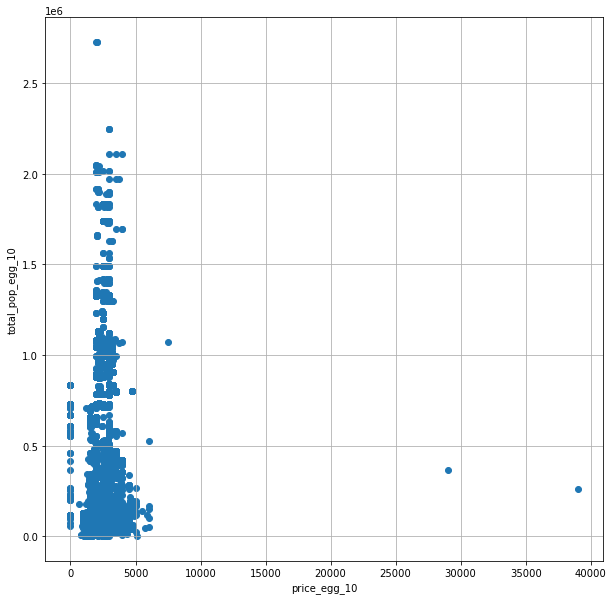

In [16]:
plt.figure(figsize=(10, 10))         # 플롯 사이즈 지정
plt.scatter(price_egg_10, total_pop_egg_10) # 산점도
plt.xlabel("price_egg_10")                  # x축 레이블 지정
plt.ylabel("total_pop_egg_10")              # y축 레이블 지정
plt.grid()                           # 플롯에 격자 보이기
plt.show()                           # 플롯 보이기

outlier 제거

In [21]:
Lower = df_egg_10['가격(원)'].mean() - 2*df_egg_10['가격(원)'].std()
Lower

431.1363175610363

In [72]:
# outlier 제거

df_egg_10_new = df_egg_10[(df_egg_10['가격(원)'] > Lower)]
df_egg_10_new = df_egg_10_new[(df_egg_10['가격(원)'] < 7000)]
df_egg_10_new = df_egg_10_new[(df_egg_10['총_생활인구_수'] < 2500000)]

price_egg_10_new = list(df_egg_10_new['가격(원)'])
total_pop_egg_10_new = list(df_egg_10_new['총_생활인구_수'])

<ipython-input-72-ec12b47e2c76>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_egg_10_new = df_egg_10_new[(df_egg_10['가격(원)'] < 7000)]
<ipython-input-72-ec12b47e2c76>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_egg_10_new = df_egg_10_new[(df_egg_10['총_생활인구_수'] < 2500000)]


In [73]:
# 피어슨 상관계수 검정

# p-value값이 0.05보다 작아서 귀무가설(H0 : r=0)을 기각해 유의하다.
# 상관계수값 = -0.3029463633816119
# 음의 상관관계 : 가격이 비싸질수록 방문객수가 줄어든다
corr = stats.pearsonr(price_egg_10_new, total_pop_egg_10_new)
corr

(0.10625574668379378, 5.1058353797361315e-21)

In [37]:
print(min(total_pop_egg_10_new),max(total_pop_egg_10_new))

1037.0 1488949.0


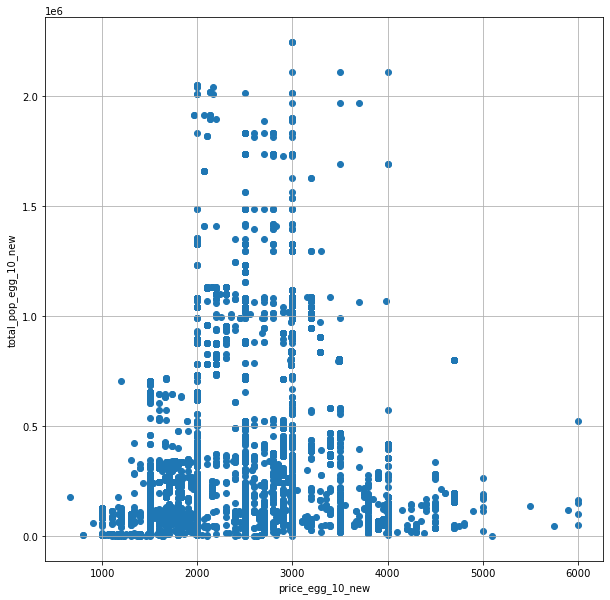

In [74]:
plt.figure(figsize=(10, 10))         # 플롯 사이즈 지정
plt.scatter(price_egg_10_new, total_pop_egg_10_new) # 산점도
#plt.axis([0, 6000, 0, 250000])
#plt.ylim(0,max(total_pop_egg_10_new))
plt.xlabel("price_egg_10_new")                  # x축 레이블 지정
plt.ylabel("total_pop_egg_10_new")              # y축 레이블 지정
plt.grid()                           # 플롯에 격자 보이기
plt.show()                           # 플롯 보이기

In [46]:
df_egg_10_copy = df_egg_10_new.copy()
df_egg_10_copy = df_egg_10_copy.rename(columns = {'가격(원)':'price','총_생활인구_수':'customer'})
df_egg_10_copy

,일련번호,시장이름,품목이름,실판매규격,price,년도-월,자치구이름,년도,분기,customer,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
8,1622889,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
22,1629971,통인시장,달걀(10개),10개(600g),2000,2020-12,종로구,2020,4,213780.0,...,548.0,588.0,769.0,524.0,932.0,760.0,511.0,532.0,703.0,508.0
52,1626783,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
75,1629377,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
81,1625200,방학동도깨비시장,달걀(10개),10개(520g),2000,2020-12,도봉구,2020,4,174184.0,...,713.0,844.0,1206.0,718.0,940.0,833.0,617.0,771.0,1084.0,669.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147280,557733,숭인시장,달걀,10개,1666,2014-01,강북구,2014,1,122068.0,...,273.0,243.0,268.0,77.0,2.0,97.0,162.0,173.0,192.0,46.0
147308,557825,노룬산골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,17006.0,...,15.0,12.0,14.0,2.0,0.0,1.0,2.0,1.0,6.0,0.0
147324,557841,자양골목시장,달걀(왕란),10개,3800,2014-01,광진구,2014,1,145674.0,...,232.0,188.0,214.0,42.0,0.0,59.0,119.0,124.0,157.0,26.0
147340,557857,마천시장,달걀(특란),10개,2900,2014-01,송파구,2014,1,109409.0,...,249.0,231.0,250.0,25.0,0.0,42.0,128.0,155.0,165.0,10.0


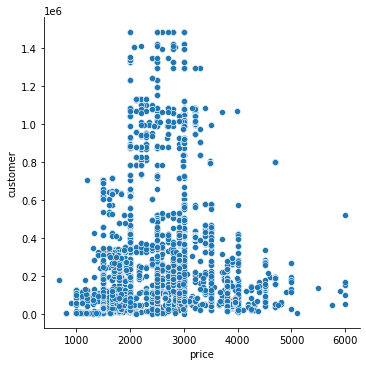

In [50]:
sns.relplot(x="price", y="customer", data=df_egg_10_copy)

sns.jointplot(data= df, x= ,y=, hue=' ' ,kind=' ')  kind기본값 scatter, 그외 종류 red,kde,hex

sns.relplot(x="total_bill", y="tip", size="size", sizes=(15, 200), data=tips)

## 쇠고기(한우,불고기)